In [1]:
from IPython import get_ipython
ip = get_ipython()
if ip is not None:
    ip.run_line_magic('load_ext', 'pymor.discretizers.builtin.gui.jupyter')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='torch')
import pymor.tools.random
pymor.tools.random._default_random_state = None

The pymor.discretizers.builtin.gui.jupyter extension is already loaded. To reload it, use:
  %reload_ext pymor.discretizers.builtin.gui.jupyter


In [2]:
from pymor.basic import *

problem = StationaryProblem(
      domain=RectDomain(),

      rhs=LincombFunction(
          [ExpressionFunction('ones(x.shape[:-1]) * 10', 2, ()), ConstantFunction(1., 2)],
          [ProjectionParameterFunctional('mu'), 0.1]),

      diffusion=LincombFunction(
          [ExpressionFunction('1 - x[..., 0]', 2, ()), ExpressionFunction('x[..., 0]', 2, ())],
          [ProjectionParameterFunctional('mu'), 1]),

      dirichlet_data=LincombFunction(
          [ExpressionFunction('2 * x[..., 0]', 2, ()), ConstantFunction(1., 2)],
          [ProjectionParameterFunctional('mu'), 0.5]),

      name='2DProblem'
  )

fom, _ = discretize_stationary_cg(problem, diameter=1/50)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [3]:
parameter_space = fom.parameters.space((0.1, 1))

In [4]:
training_set = parameter_space.sample_uniformly(100)
validation_set = parameter_space.sample_randomly(20)

In [5]:
from pymor.reductors.neural_network import NeuralNetworkReductor

reductor = NeuralNetworkReductor(fom,
                                 training_set,
                                 validation_set,
                                 l2_err=1e-5,
                                 ann_mse=1e-5)

In [6]:
rom = reductor.reduce(restarts=100)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

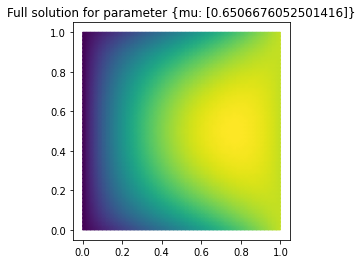

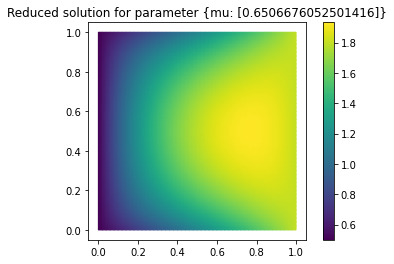

Output()

In [7]:
mu = parameter_space.sample_randomly(1)[0]

U = fom.solve(mu)
U_red = rom.solve(mu)
U_red_recon = reductor.reconstruct(U_red)

fom.visualize((U, U_red_recon),
              legend=(f'Full solution for parameter {mu}', f'Reduced solution for parameter {mu}'))

In [8]:
test_set = parameter_space.sample_randomly(10)

In [9]:
U = fom.solution_space.empty(reserve=len(test_set))
U_red = fom.solution_space.empty(reserve=len(test_set))

speedups = []

In [10]:
import time

for mu in test_set:
    tic = time.perf_counter()
    U.append(fom.solve(mu))
    time_fom = time.perf_counter() - tic

    tic = time.perf_counter()
    U_red.append(reductor.reconstruct(rom.solve(mu)))
    time_red = time.perf_counter() - tic

    speedups.append(time_fom / time_red)

Accordion(children=(HTML(value='', layout=Layout(height='16em', overflow_y='auto', width='100%')),), selected_…

In [11]:
absolute_errors = (U - U_red).norm()
relative_errors = (U - U_red).norm() / U.norm()

In [12]:
import numpy as np

np.average(absolute_errors)

0.005038819595248249

In [13]:
np.average(relative_errors)

6.581236587323919e-05

In [14]:
np.median(speedups)

10.063473656954127